In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from web3 import Web3
warnings.filterwarnings('ignore')

from utils.analysis import filter_date, count_unique_addresses, sum_value

In [15]:
token_name = 'LQTY'
data_date = '2022-07-12'
start_date = '2021-04-05'
end_date = '2022-07-11'
infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d'

In [16]:
data_date = datetime.strptime(data_date, '%Y-%m-%d')
data_date_str = data_date.strftime('%y-%m-%d')

start_date = datetime.strptime(start_date, '%Y-%m-%d')
start_date_str = start_date.strftime('%y-%m-%d')

end_date = datetime.strptime(end_date, '%Y-%m-%d')
end_date_str = end_date.strftime('%y-%m-%d')

DATA_DIR = f'../Data/{token_name}_{data_date_str}'
FIGURE_DIR = f'../Figure/{token_name}_{start_date_str}_{end_date_str}'

if os.path.exists(FIGURE_DIR) is False:
    os.makedirs(FIGURE_DIR)

In [17]:
print('Token name: {}'.format(token_name))
print('Token genesis date: {}'.format('2021-04-05' if token_name=='LQTY' else '2021-04-15'))
print('The last date of the collected data: {}'.format(data_date_str))
print('Analysis start date: {}'.format(start_date_str))
print('Analysis end date: {}'.format(end_date_str))
print('--------------------------------------------------\n')

Token name: LQTY
Token genesis date: 2021-04-05
The last date of the collected data: 22-07-12
Analysis start date: 21-04-05
Analysis end date: 22-07-11
--------------------------------------------------



## Read data =======

In [48]:
# Raw transaction date
dtypes = {'token_address':str, 'from_address':str, 'to_address':str, 'timestamp':str, 'value':np.float64}
raw_tx = pd.read_csv(f'../Data/{token_name}_{data_date_str}.csv', dtype=dtypes)
raw_tx['timestamp'] = pd.to_datetime(raw_tx['timestamp'])
raw_tx = filter_date(raw_tx, start_date=start_date, end_date=end_date)

# Aggregated transaction date
dtypes = {'timestamp':str, 'from_address':str, 'to_address':str, 'value':np.float64}
agg_tx = pd.read_csv(f'{DATA_DIR}/01_agg_tx.csv', dtype=dtypes)
agg_tx['timestamp'] = pd.to_datetime(agg_tx['timestamp'])
agg_tx = filter_date(agg_tx, start_date=start_date, end_date=end_date)

# Network features
network_fea = pd.read_csv(f'{DATA_DIR}/02_network_fea.csv')
network_fea['timestamp'] = pd.to_datetime(network_fea['timestamp'])
network_fea = filter_date(network_fea, start_date=start_date, end_date=end_date)
network_fea.rename(columns={'significance': 'cp_pvalue'}, inplace=True)

# Addresses that have been the core nodes
core_address = pd.read_csv(f'{DATA_DIR}/03_core_address.csv')

plt.style.use('seaborn-muted')

## Analysis & Visualization =======

#### ======= Figure 1 =======

======= Figure 1 =======
Saved: ../Figure/LQTY_21-04-05_22-07-11/1_basic_trending.png



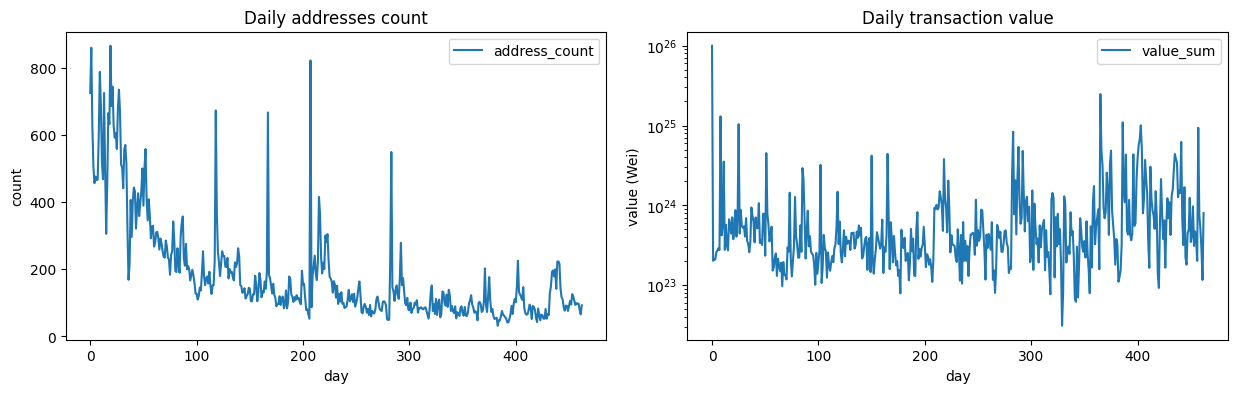

In [51]:
# Preprocess data
network_fea['address_count'] = raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']
network_fea['value_sum'] = agg_tx.groupby('timestamp').apply(sum_value).reset_index().drop(columns=['level_1'])['value_sum']

# ======= Figure 1 =======
# Basic trending
print('======= Figure 1 =======')
fig, axes = plt.subplots(1,2)
plt.style.use('default')
# Addresses count
network_fea[['address_count']].plot(ax=axes[0], figsize=(15,4), grid=False, title='Daily addresses count', xlabel='day', ylabel='count')
# Tx daily value
ax = network_fea[['value_sum']].plot(ax=axes[1], figsize=(15,4), grid=False, title='Daily transaction value', xlabel='day', ylabel='value (Wei)')
ax.set_yscale('log')

plt.subplots_adjust(wspace =0.15, hspace =1.35)

plt.savefig(f'{FIGURE_DIR}/1_basic_trending.png', dpi=300, bbox_inches = 'tight')
print(f'Saved: {FIGURE_DIR}/1_basic_trending.png\n')

#### ======= Figure 2 =======

======= Figure 2 =======
Significant days VS Insignificant days: 349 (75.38%) | 114 (24.62%)
Saved: ../Figure/LQTY_21-04-05_22-07-11/2_days_sig_vs_insig.png



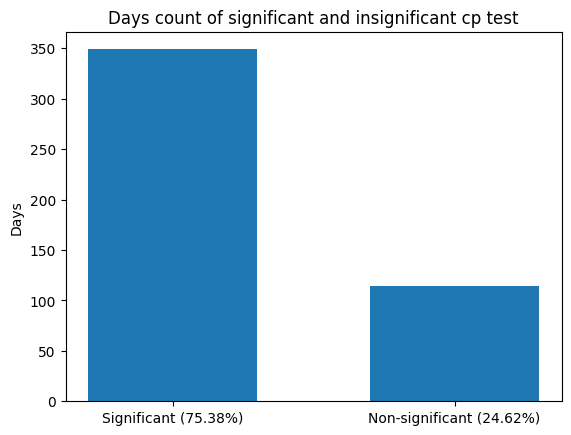

In [26]:
# ======= Figure 2 =======
# Distribution on significant & insignificant days 
print('======= Figure 2 =======')
sig_T = network_fea[network_fea['cp_pvalue'] < 0.05]
sig_F = network_fea[network_fea['cp_pvalue'] >= 0.05]

sig_per = 100*len(sig_T)/len(network_fea)
insig_per = 100*sig_F.shape[0]/network_fea.shape[0]

fig, ax = plt.subplots()
ax.bar(
    ['Significant ({:.4}%)'.format(sig_per), 'Non-significant ({:.4}%)'.format(insig_per)], 
    [len(sig_T), len(sig_F)], width = 0.6, 
)

ax.set_title('Days count of significant and insignificant cp test')
ax.set_ylabel('Days')

plt.savefig(f'{FIGURE_DIR}/2_days_sig_vs_insig.png')

print('Significant days VS Insignificant days: {} ({:.4}%) | {} ({:.4}%)'.format(len(sig_T), sig_per, sig_F.shape[0], insig_per))
print(f'Saved: {FIGURE_DIR}/2_days_sig_vs_insig.png\n')

#### ======= Figure 3 =======

======= Figure 3 =======
Saved: ../Figure/LQTY_21-04-05_22-07-11/3_core_sig_vs_insig.png



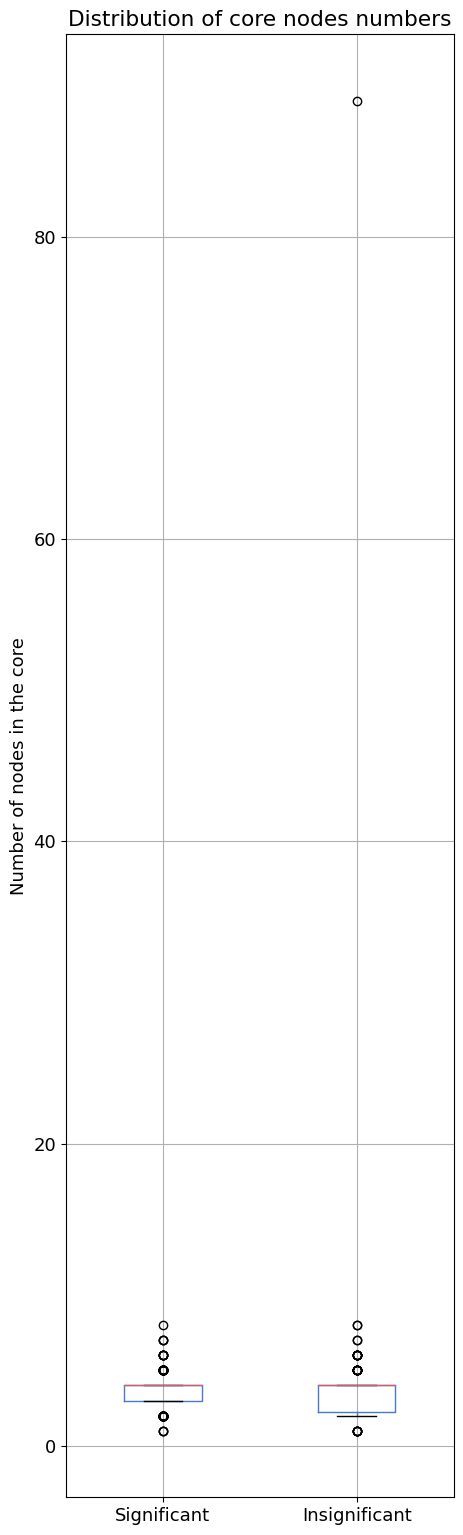

In [31]:
# ======= Figure 3 =======
# Distribution of core nodes numbers
print('======= Figure 3 =======')
num_core_sig_T = sig_T['num_core']
num_core_sig_F = sig_F['num_core']

# fig, ax = plt.subplots()
# plt.style.use('seaborn-muted')
plt.figure(figsize=(5, 19))
dt = pd.DataFrame({'Significant':num_core_sig_T, 'Insignificant':num_core_sig_F})
dt.boxplot(widths = 0.4, whis=0.5)

plt.title('Distribution of core nodes numbers')
plt.ylabel('Number of nodes in the core')
plt.rc('font', size=13) # controls default text sizes
plt.savefig(f'{FIGURE_DIR}/3_core_sig_vs_insig.png')
print(f'Saved: {FIGURE_DIR}/3_core_sig_vs_insig.png\n')

#### ======= Figure 4 =======

======= Figure 4 =======
Saved: ../Figure/LQTY_21-04-05_22-07-11/4_avg_core_neighber_sig_vs_insig.png



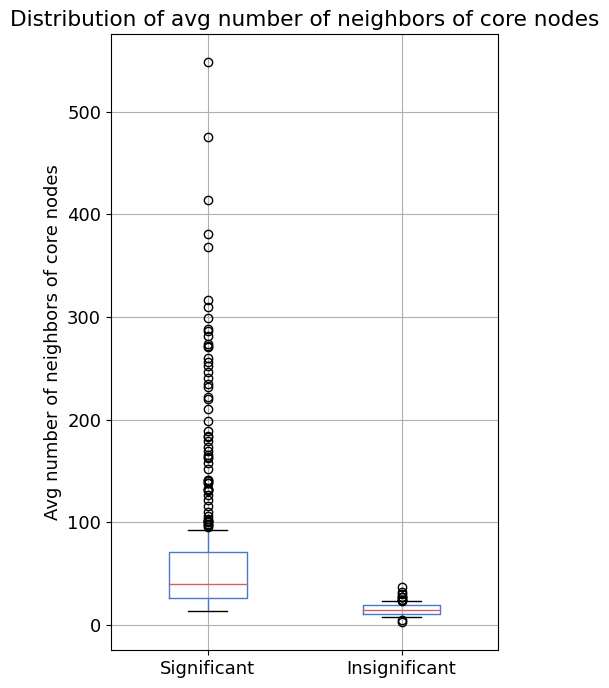

In [32]:
# ======= Figure 4 =======
# Distribution of avg number of neighbors of core nodes
print('======= Figure 4 =======')
avg_core_neighbor_sig_T = sig_T['avg_core_neighbor']
avg_core_neighbor_sig_F = sig_F['avg_core_neighbor']

plt.figure(figsize=(5, 8))
dt = pd.DataFrame({'Significant':avg_core_neighbor_sig_T, 'Insignificant':avg_core_neighbor_sig_F})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Distribution of avg number of neighbors of core nodes')
plt.ylabel('Avg number of neighbors of core nodes')
plt.rc('font', size=13)
plt.savefig(f'{FIGURE_DIR}/4_avg_core_neighber_sig_vs_insig.png', dpi=300)
print(f'Saved: {FIGURE_DIR}/4_avg_core_neighber_sig_vs_insig.png\n')

#### ======= Figure 5 =======

======= Figure 5 =======
Updated: ../Data/LQTY_22-07-12/03_core_address.csv
CA VS EOA: 45 (39.13%) | 70 (60.87%)
Saved: ../Figure/LQTY_21-04-05_22-07-11/5_core_days_count_CA_vs_EOA.png



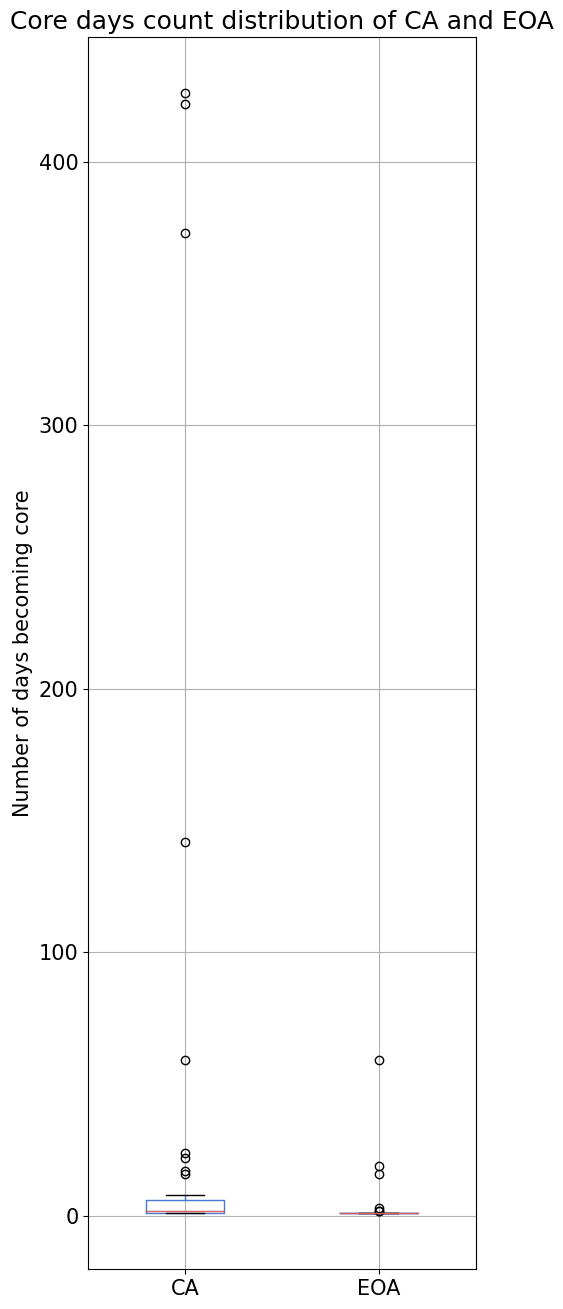

In [34]:
# ======= Figure 5 =======
# Core days count distribution of CA and EOA
print('======= Figure 5 =======')
# Get the type (CA/EOA) of each address via Web3.py
infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d' #args.infura_url
web3 = Web3(Web3.HTTPProvider(infura_url))

core_address['type'] = core_address['address'].apply(lambda x: 1 if web3.eth.get_code(Web3.toChecksumAddress(x)).hex()=='0x' else 0)
core_address.to_csv(f'{DATA_DIR}/03_core_address.csv', index=False)
print(f'Updated: {DATA_DIR}/03_core_address.csv')
core_CA = core_address[core_address['type'] == 0]
core_EOA = core_address[core_address['type'] == 1]

print('CA VS EOA: {} ({:.4}%) | {} ({:.4}%)'.format(len(core_CA), 100*len(core_CA)/len(core_address), core_EOA.shape[0], 100*core_EOA.shape[0]/core_address.shape[0]))

plt.style.use('seaborn-muted')
plt.figure(figsize=(5, 16))
dt = pd.DataFrame({'CA':core_CA['core_days_cnt'], 'EOA':core_EOA['core_days_cnt']})
dt.boxplot(widths = 0.4,whis=0.5)
plt.title('Core days count distribution of CA and EOA')
plt.ylabel('Number of days becoming core')
plt.rc('font', size=15)
plt.savefig(f'{FIGURE_DIR}/5_core_days_count_CA_vs_EOA.png')
print(f'Saved: {FIGURE_DIR}/5_core_days_count_CA_vs_EOA.png\n')

Saved: ../Figure/LQTY_21-04-05_22-07-11/5_core_days_count_CA_vs_EOA.png



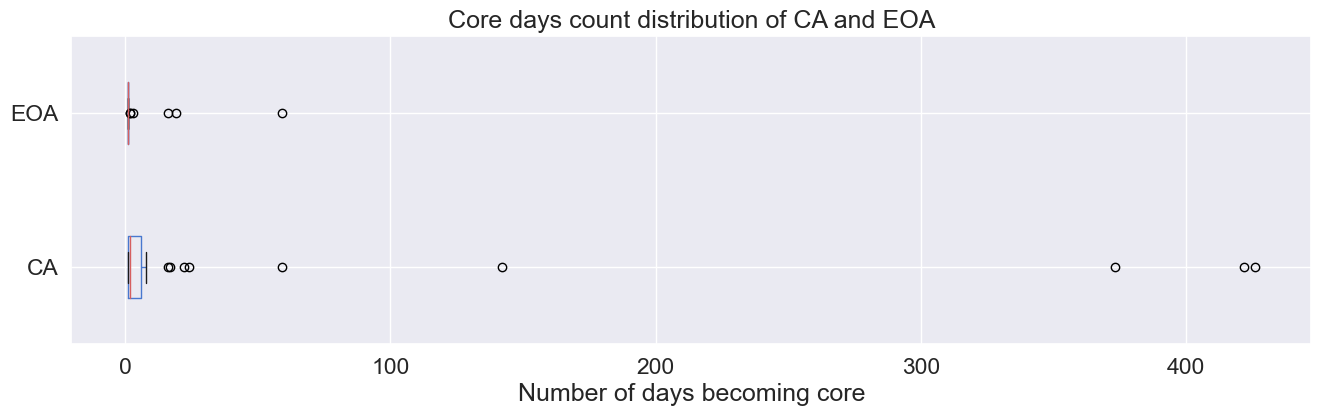

In [46]:
# plt.style.use('seaborn-muted')
plt.figure(figsize=(16, 4))
dt = pd.DataFrame({'CA':core_CA['core_days_cnt'], 'EOA':core_EOA['core_days_cnt']})
dt.boxplot(widths = 0.4,whis=0.5,vert=False)
plt.title('Core days count distribution of CA and EOA')
plt.xlabel('Number of days becoming core')
plt.rc('font', size=15)
plt.savefig(f'{FIGURE_DIR}/5_core_days_count_CA_vs_EOA.png', dpi=300, bbox_inches = 'tight')
plt.subplots_adjust(wspace =0.15, hspace =1.35)
print(f'Saved: {FIGURE_DIR}/5_core_days_count_CA_vs_EOA.png\n')

#### ======= Figure 6 =======

======= Figure 6 =======
Saved: ../Figure/LQTY_21-04-05_22-07-11/6_network_dynamics.png



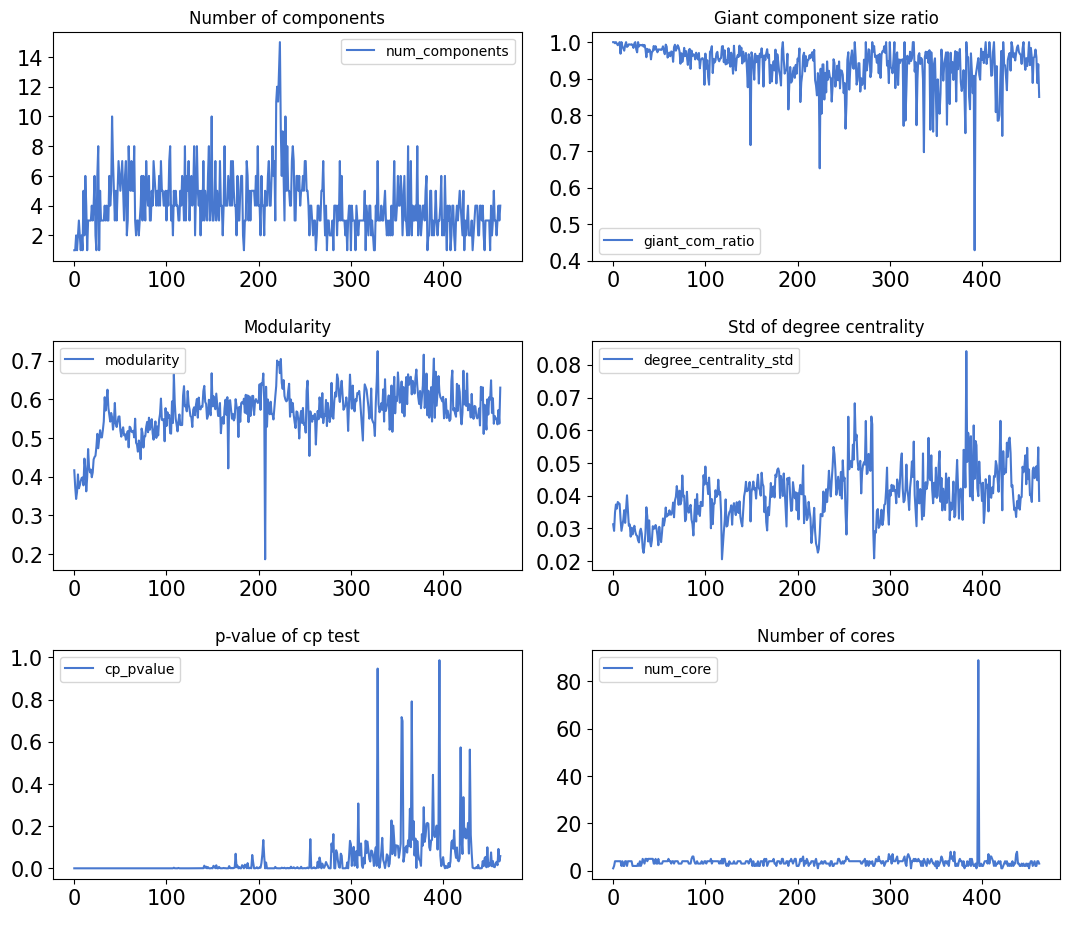

In [35]:
# ======= Figure 6 =======
# Network Dynamics
print('======= Figure 6 =======')
fig,axes = plt.subplots(3,2)
plt.style.use('default')

# Number of components
ax = network_fea[['num_components']].plot(ax=axes[0,0], figsize=(13,10), grid=False, title='Number of components', xlabel=' ')
# ax.set_yscale('log')

# Gaint component ratio
network_fea[['giant_com_ratio']].plot(ax=axes[0,1], figsize=(13,7), grid=False, title='Giant component size ratio', xlabel=' ')

# Modularity
network_fea[['modularity']].plot(ax=axes[1,0], figsize=(13,7), grid=False, title='Modularity', xlabel=' ')

# Std of degree centrality
network_fea[['degree_centrality_std']].plot(ax=axes[1,1], figsize=(13,7), grid=False, title='Std of degree centrality',xlabel=' ')

# p-value of cp test
network_fea[['cp_pvalue']].plot(ax=axes[2,0], figsize=(13,11), grid=False, title='p-value of cp test', xlabel=' ')

# Number of cores
network_fea[['num_core']].plot(ax=axes[2,1], figsize=(13,11), grid=False, title='Number of cores', xlabel=' ')

plt.subplots_adjust(wspace =0.15, hspace =0.35)
plt.savefig(f'{FIGURE_DIR}/6_network_dynamics.png', dpi=300)
print(f'Saved: {FIGURE_DIR}/6_network_dynamics.png\n')

#### ======= Figure 7 =======

======= Figure 7 =======
Saved: ../Data/LQTY_22-07-12/04_correlation.csv
Saved: ../Figure/LQTY_21-04-05_22-07-11/7_correlation_heatmap.png



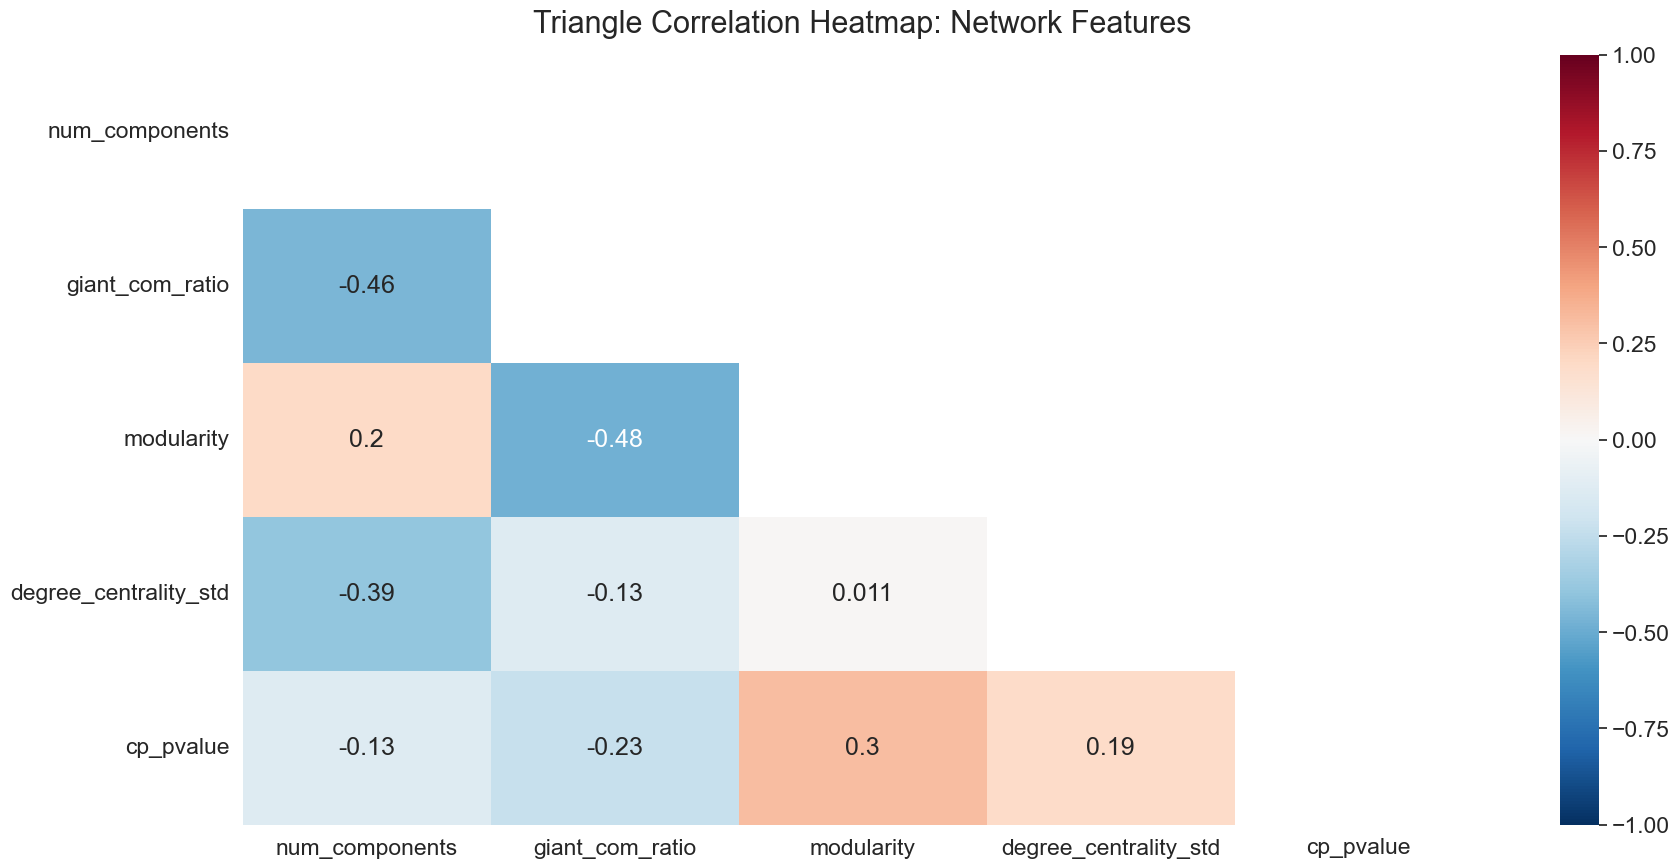

In [36]:
# ======= Figure 7 =======
# Correlation Heatmap
print('======= Figure 7 =======')
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'cp_pvalue']].corr()
network_fea_cor.to_csv(f'{DATA_DIR}/04_correlation.csv', index=False)
print(f'Saved: {DATA_DIR}/04_correlation.csv')

plt.style.use('default')
plt.figure(figsize=(20, 10))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r') #control colors: https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/#:~:text=You%20can%20customize%20the%20colors,heatmap()%20function%20in%20seaborn.&text=It%20is%20also%20possible%20to,vmin%20parameters%20in%20the%20function.
heatmap.set_title('Triangle Correlation Heatmap: Network Features', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f'{FIGURE_DIR}/7_correlation_heatmap.png', dpi=300)
print(f'Saved: {FIGURE_DIR}/7_correlation_heatmap.png\n')